In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output
import logging
import tensorflow as tf

print('All librairies sucessfully imported.')

All librairies sucessfully imported.


In [2]:
# import data
PATH_COLAB = '/content/drive/MyDrive/6_aneurysm_segmentation/challenge_dataset.zip'
PATH_DEVICE = './challenge_dataset/'

try:
    from google.colab import drive
    logging.info('Working on Colab.')
    
    # connect your drive to the session
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/6_aneurysm_segmentation/

    # unzip data into the colab session
    ! unzip $PATH_COLAB -d /content
    logging.info('Data unziped in your Drive.')

except:
    logging.info('Working on your device.')
    
    data_exists = os.path.exists(PATH_DEVICE)
    
    if data_exists:
        logging.info(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

# Data Generator

Tout est caché dans utils.py et a fonction `instantiate_generator`.

In [3]:
from utils import instantiate_generator

train_data_pipeline, val_data_pipeline = instantiate_generator(train_size=0.8)

Dataset found on device at : './challenge_dataset/.'


# UNet3D

In [9]:
from keras.layers import BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D, Activation, Input
from keras.layers import MaxPooling3D, UpSampling3D, Conv3DTranspose, concatenate
from keras.models import Model


# input shape without batch size and we add one channel for BW color so dim=4
in_layer = Input((None, None, None, 1)) 
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3])

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2])

pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'sigmoid')(pre_out)

pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
out = ZeroPadding3D((1, 2, 2))(pre_out)
model = Model(inputs = [in_layer], outputs = [out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   4          ['input_1[0][0]']                
 alization)                     None, 1)                                                          
                                                                                                  
 conv3d (Conv3D)                (None, None, None,   208         ['batch_normalization[0][0]']    
                                None, 8)                                                      

# Define losses

In [57]:
import keras.backend as K

def custom_iou(smooth=1e-6):
    def IoULoss(targets, inputs):
        targets = tf.cast(targets, tf.float32)

        # flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)

        intersection = K.sum(targets * inputs)
        # intersection = K.sum(K.dot(targets, inputs))

        total = K.sum(targets) + K.sum(inputs)

        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU

    return IoULoss

In [58]:
def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return 1 - jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

# Compile model

In [59]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# choose your loss
# loss = 'binary_crossentropy'
loss = custom_iou()
# loss = jacard_coef_loss

# compile your model
model.compile(optimizer='adam', 
              loss=loss, 
              metrics = ['binary_accuracy', 'mse'])

# add callbacks to monitor training 
weight_path="{}_weights.best.hdf5".format('model')
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, 
                                   patience=5, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001, 
                                   cooldown=5, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

# Training

In [60]:
model.fit(train_data_pipeline, 
            epochs=50,
            validation_data=val_data_pipeline, 
            verbose=1,
            callbacks=callbacks_list)

Epoch 1/50
     21/Unknown - 12s 530ms/step - loss: 0.9996 - binary_accuracy: 0.4171 - mse: 0.5708
Epoch 1: val_loss improved from inf to 0.99958, saving model to model_weights.best.hdf5
21/21 [==============================] - 14s 600ms/step - loss: 0.9996 - binary_accuracy: 0.4171 - mse: 0.5708 - val_loss: 0.9996 - val_binary_accuracy: 0.4202 - val_mse: 0.5754 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.9995 - binary_accuracy: 0.5745 - mse: 0.4089
Epoch 2: val_loss improved from 0.99958 to 0.99948, saving model to model_weights.best.hdf5
21/21 [==============================] - 12s 593ms/step - loss: 0.9995 - binary_accuracy: 0.5745 - mse: 0.4089 - val_loss: 0.9995 - val_binary_accuracy: 0.5352 - val_mse: 0.4623 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9991 - binary_accuracy: 0.7621 - mse: 0.2303
Epoch 3: val_loss improved from 0.99948 to 0.99917, saving model to model_weights.best.hdf5
21/21 [==========

# Model evaluation

1/1 [==============================] - 0s 93ms/step


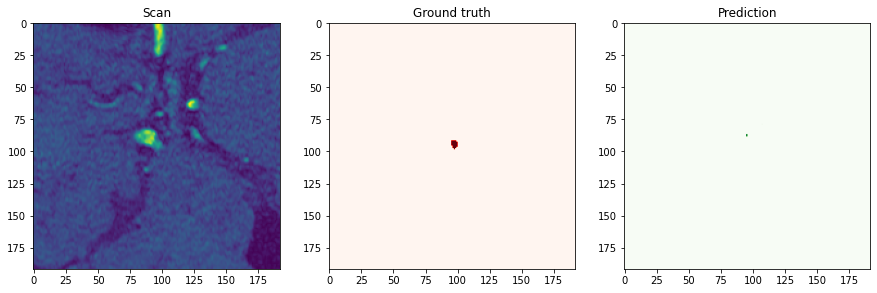

In [63]:
import matplotlib.pyplot as plt
from keras.models import load_model

# load model from checkpoint
model.load_weights('/content/drive/MyDrive/6_aneurysm_segmentation/model_weights.best.hdf5')

x, y = next(iter(val_data_pipeline))
idx = 0
depth = 31

im = x[idx, depth]
lbl = y[idx, depth]
pred = model.predict(x)[idx, depth].squeeze()

# plot original VS ground truth VS pred
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(im)
ax[0].set(title='Scan')
ax[1].imshow(lbl, cmap='Reds')
ax[1].set(title='Ground truth')
ax[2].imshow(pred, cmap='Greens')
ax[2].set(title='Prediction')
plt.show()

In [15]:
model.evaluate(val_data_pipeline)

6/6 [==============================] - 1s 161ms/step - loss: 0.5002 - binary_accuracy: 0.9999 - mse: 1.1928e-04


[0.500194787979126, 0.999872088432312, 0.00011928045569220558]